In [2]:
import os
os.chdir('..')

In [3]:
import cv2
from matplotlib import pyplot as plt

In [4]:
image_file_folder = 'data/raw_video/sliced_videos'
files = sorted(os.listdir(image_file_folder))
files = [ os.path.join(image_file_folder, f) for f in files if f.endswith('.png') ]

In [5]:
from src import img_utils
from jax import numpy as jnp
import jax

In [6]:
vid = [ cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in files[:2] ]

In [7]:
@jax.jit
def find_velocity(arr):

    M = jnp.array(jnp.vstack([arr[2:4], arr[3:5]])).copy()
    b = arr.copy()[-2:].reshape((2, 1))

    cond1 = jnp.linalg.norm(arr[:2]) < 2
    cond2 = jnp.linalg.cond( M ) > 1e2
    cond = cond1 | cond2

    result = jax.lax.cond(
        cond, 
        lambda M, b: jnp.zeros((2, 1)),
        lambda M, b: -jnp.linalg.inv(M) @ b,
        M, b
    )

    return result


In [8]:
@jax.jit
def velocities_from_video(video_frames):
    p        = jnp.array([0.5, 0.5])
    d        = jnp.array([-1, 1])
    mean_vid = 0.5*video_frames[0] + 0.5*video_frames[1]

    fx = img_utils.sepfir2( mean_vid, d, p )
    fy = img_utils.sepfir2( mean_vid, p, d )
    ft = img_utils.sepfir2( vid[0] - vid[1], p, p)

    h   = jnp.array([1/16, 4/16, 6/16, 4/16, 1/16])
    fx2 = img_utils.sepfir2( fx*fx, h, h )
    fy2 = img_utils.sepfir2( fy*fy, h, h )
    fxy = img_utils.sepfir2( fx*fy, h, h )
    fxt = img_utils.sepfir2( fx*ft, h, h )
    fyt = img_utils.sepfir2( fy*ft, h, h )

    combined = jnp.array([ fx.flatten(), fy.flatten(), fx2.flatten(), fxy.flatten(), fy2.flatten(), fxt.flatten(), fyt.flatten() ])
    velocity = jax.vmap(find_velocity, in_axes=(1))(combined)
    velocity = velocity.reshape(velocity.shape[0], 2)
    
    image_shape = fx2.shape
    vx = velocity[:, 0].reshape(image_shape)
    vy = velocity[:, 1].reshape(image_shape)

    return vx, vy

In [9]:
import time

In [10]:
start = time.perf_counter()
velocity = velocities_from_video( vid )
taken = time.perf_counter() - start 
print(taken)

0.6076638450031169


In [11]:
1/taken

1.6456466979615527

In [12]:
from src import video_utils

0 2
1 2
2 2
3 2


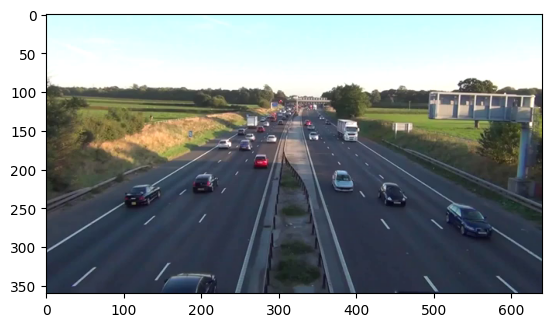

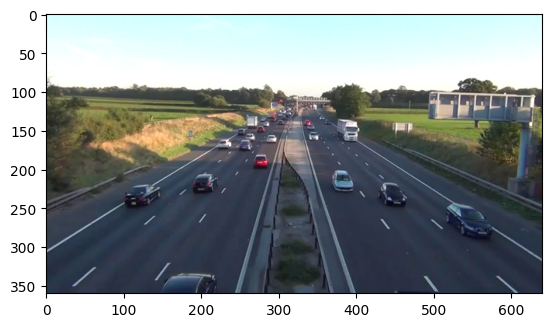

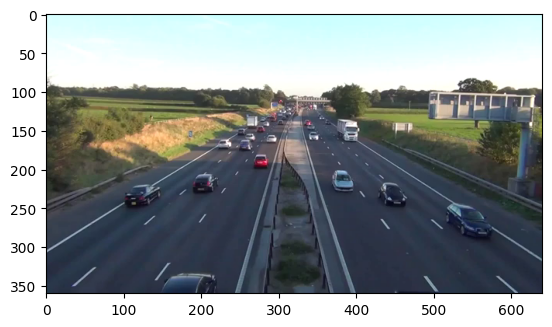

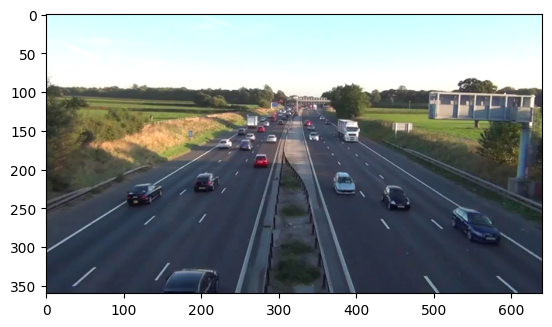

In [13]:
videos = video_utils.VideoSource('data/raw_video/Road traffic video for object recognition.mp4', n_slices=2)
for i, images in zip(range(4), videos):
    print(i, len(images))
    image = images[0]
    plt.figure()
    plt.imshow(image)


In [15]:
from src import img_utils

In [16]:
gs = img_utils.rgb_to_greyscale(image)

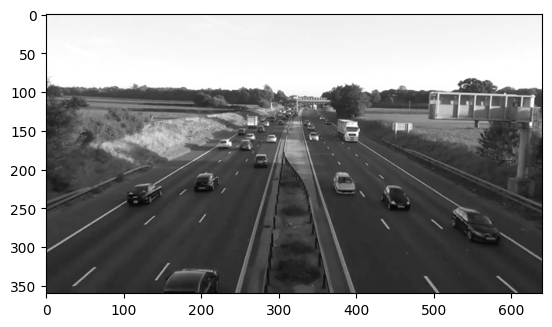

In [19]:
plt.imshow(gs, cmap='grey')